# Seminario de Ciencia de Datos

## 2º Cuatrimestre de 2017

## Módulo 6 - Procesamiento del Lenguaje Natural

### Integrantes:

- Mascitti, Julio Augusto - 954/11 - mascittija@gmail.com

- Aleman, Damián - 377/10 - damianaleman@gmail.com

- Guerson, Matias Carlos - 925/10 - matias.guerson@gmail.com

In [2]:
import os
import xml.etree.ElementTree
import nltk
from nltk import bigrams
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet, wordnet_ic
from nltk.tokenize import wordpunct_tokenize
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import functools
import random
import operator as op
import re
from gensim import models, corpora
import scipy as sp
import sklearn as sk
import warnings
warnings.filterwarnings('ignore')
#nltk.download()

## Asociación de palabras

### 1) Levantar el corpus AP, separando cada noticia como un elemento distinto en un diccioinario

In [8]:
# Se escapearon los & en el archivo y se agregaron los tags <DOCS> para poder parsearlo como un xml
inputXML = './data/ap/ap.txt'
e = xml.etree.ElementTree.parse(inputXML).getroot()
docs = {}

for elem in e.getchildren():
    text = elem.find('TEXT').text
    docno = elem.find('DOCNO').text.strip()
    docs[docno] = text

# Imprimimos el primer documento a modo de ejemplo 
list(docs.items())[0]

('AP881218-0003',
 "\n A 16-year-old student at a private Baptist school who allegedly killed one teacher and wounded another before firing into a filled classroom apparently ``just snapped,'' the school's pastor said. ``I don't know how it could have happened,'' said George Sweet, pastor of Atlantic Shores Baptist Church. ``This is a good, Christian school. We pride ourselves on discipline. Our kids are good kids.'' The Atlantic Shores Christian School sophomore was arrested and charged with first-degree murder, attempted murder, malicious assault and related felony charges for the Friday morning shooting. Police would not release the boy's name because he is a juvenile, but neighbors and relatives identified him as Nicholas Elliott. Police said the student was tackled by a teacher and other students when his semiautomatic pistol jammed as he fired on the classroom as the students cowered on the floor crying ``Jesus save us! God save us!'' Friends and family said the boy apparently wa

In [9]:
def get_wordnet_pos(tag):

    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [10]:
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english') +  list(string.punctuation)
vocabulary = {}
bigrams_map = {}
docs_words = {}

# Preprocesamiento
# Para calcular el tamaño del vocabulario, primero, por cada documento, 
# separamos en frases, luego estas en palabras, taggeamos y lematizamos.
# Cada lema es un elemento de nuestro vocabulario.

# Por otro lado, nos vamos guardando los bigramas para el punto 3.

for docno, text in docs.items():
    docs_words[docno] = []
    sentences = nltk.sent_tokenize(text)
    for sentence in sentences:
        tokens = nltk.word_tokenize(sentence)
        
        for bigram in bigrams(tokens):
            if (bigram[0] not in stop_words) and (bigram[1] not in stop_words):
                bigrams_map.setdefault((bigram[0], bigram[1]), 0)
                bigrams_map.setdefault((bigram[1], bigram[0]), 0)
                bigrams_map[bigram[0],bigram[1]] = bigrams_map[bigram[0],bigram[1]] + 1
                bigrams_map[bigram[1],bigram[0]] = bigrams_map[bigram[1],bigram[0]] + 1
        tags = nltk.pos_tag(tokens)
        for word, tag in tags:
            wornet_pos = get_wordnet_pos(tag)
            if wornet_pos:
                lemma = lemmatizer.lemmatize(word, wornet_pos)
            else:
                lemma = lemmatizer.lemmatize(word)
            if lemma not in stop_words:
                vocabulary.setdefault(lemma, 0)
                vocabulary[lemma] = vocabulary[lemma] + 1
                docs_words[docno].append(lemma.upper())


### 2) Calcular el tamaño del vocabulario

In [11]:
print("El tamaño del vocabulario es", len(vocabulary))

El tamaño del vocabulario es 41169


### 3) Para las 500 palabras con más apareiciones, calcular el par más asociado según la medida presentada

In [12]:
first_500 = list(map(lambda x: x[0], sorted(vocabulary.items(), key=lambda x: x[1], reverse=True)[:500]))
ordered_bigrams = sorted(bigrams_map.items(), key=lambda x: x[1], reverse=True)

for word in first_500:
    for bigram_entry in ordered_bigrams:
        if bigram_entry[0][0] == word:
            print(word, ",", bigram_entry[0][1])
            break


say , officials
`` , I
'' , said
's , It
The , ``
year , last
would , n't
I , ``
percent , 20
He , said
million , shares
n't , ca
people , million
one , said
also , said
government , 's
make , sure
It , ``
U.S. , District
In , ``
two , years
official , said
report , said
last , year
go , would
take , place
But , ``
A , ``
time , first
state , 's
could , n't
Bush , 's
We , ``
include , would
new , The
get , n't
day , one
first , time
tell , n't
Soviet , Union
week , last
New , York
United , States
company , 's
use , drug
call , 's
billion , 1
work , n't
month , last
country , 's
give , would
come , n't
today , said
plan , 's
president , vice
police , said
Thursday , said
American , people
three , years
group , The
States , United
since , time
Tuesday , said
market , stock
member , states
price , bid
President , Bush
issue , The
Monday , said
Friday , said
high , school
force , task
Wednesday , said
They , ``
know , n't
think , I
want , n't
find , n't
begin , would
charge , possession
le

## Informació Léxica

### 1) Procesar el texto, tokenizando eliminando signos de puntuación

In [15]:
# Procesamos el texto, tokenizamos eliminando los signos de puntuación

punctuation = list(string.punctuation)
tokens = []
with open('./data/on-the-origin-of-species.txt') as file:  
    data = file.read() 
    tokens = list(filter(lambda x: x not in punctuation, nltk.word_tokenize(data)))
    
# Imprimimos a modo de ejemplo los primeros 20 tokens
list(tokens)[:20]

['ï',
 '»',
 '¿Produced',
 'by',
 'Sue',
 'Asscher',
 'THE',
 'ORIGIN',
 'OF',
 'SPECIES',
 'BY',
 'MEANS',
 'OF',
 'NATURAL',
 'SELECTION',
 'or',
 'the',
 'PRESERVATION',
 'OF',
 'FAVOURED']

### 2) Siguiendo el articulo de la sección, calcular la autocorrelacion para estimar la distribución de la palabra a lo largo del texto

In [17]:
words = ['plants', 'instinct', 'for']

def generate_apparitions_vector(word,tokens):
    return [i for i, x in enumerate(tokens) if x == word]

std = 50
std_square = std ** 2
twice_std_square = 2 * std_square
denominator = np.sqrt(2 * np.pi) * std

def gaussian(x):
    x_square = x ** 2 
    exp = (-1) * (x_square / twice_std_square) 
    numerator = np.e ** exp
    return numerator / denominator

text_size = len(tokens)
gaussians = {}
for i in range(text_size):
    gaussians[i] = gaussian(i)
    gaussians[-i] = gaussian(-i)
    
def ro_w(t, apparitions):
    sum = 0
    for i in apparitions:
        sum += gaussians[t - i]
    return sum

def plot_apparitions_from(word, ro_vector):
    a = [ro_vector[i] for i in range(text_size)]
    plt.plot(a)
    plt.title('Apariciones de ' + word)
    plt.xlabel('Posición del texto')
    plt.ylabel('Rate')
    plt.show()
    
    
def calcular_autocorrelacion(tau,ro_vector):
    tamanio = text_size - tau

    acum_ro_i = 0
    acum_ro_it = 0
    acum_ro_i_it = 0
    acum_ro_i_2 = 0
    
    for i in range(tamanio):
        ro_i = ro_vector[i]
        ro_it = ro_vector[i+tau]

        acum_ro_i += ro_i
        acum_ro_it += ro_it
        acum_ro_i_it += ro_i * ro_it

        acum_ro_i_2 += ro_i ** 2

    prom_ro_i_it = acum_ro_i_it / tamanio
    prom_ro_i = acum_ro_i / tamanio
    prom_ro_it = acum_ro_it / tamanio
    prom_ro_i_2 = acum_ro_i_2 / tamanio
    square_prom_ro_i = prom_ro_i ** 2
    
    autocorrelacion = (prom_ro_i_it - (prom_ro_i * prom_ro_it)) / (prom_ro_i_2 - square_prom_ro_i)
    return autocorrelacion

def plot_autocorrelation_from(word, ro_vector):
    rangos = np.arange(0, 10000, 50) #[10, 50, 100, 250, 500, 750, 1000]

    a = [calcular_autocorrelacion(tao,ro_vector) for tao in rangos]
    plt.plot(a)
    plt.title('Autocorrelación de ' + word)
    plt.xlabel('Posición del texto')
    plt.ylabel('Autocorrelación')
    plt.show()
    
    
def calculate_ro_vector(apparitions):
    ro_vector = [ro_w(i, apparitions) for i in range(text_size)]
    return ro_vector


def graficos(words,tokens):
    for word in words:
        apparitions = generate_apparitions_vector(word,tokens)

        ro_vector = calculate_ro_vector(apparitions)
        
        plot_apparitions_from(word, ro_vector)
        plot_autocorrelation_from(word, ro_vector)

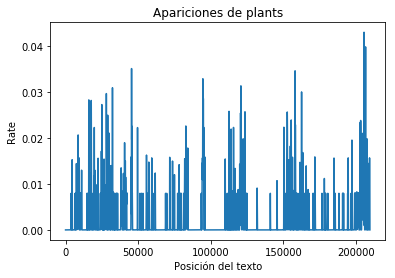

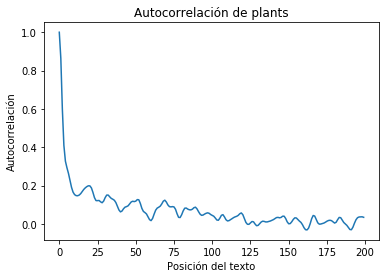

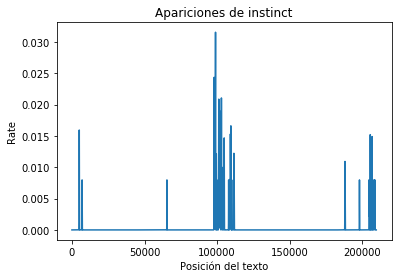

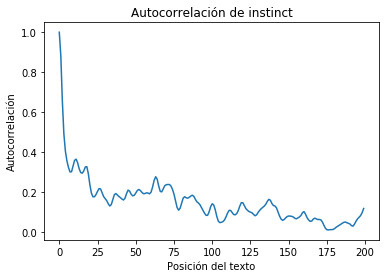

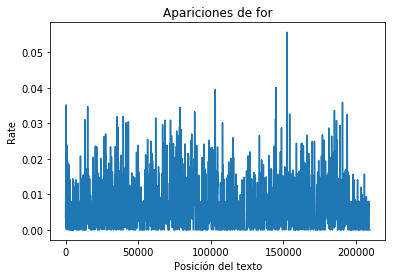

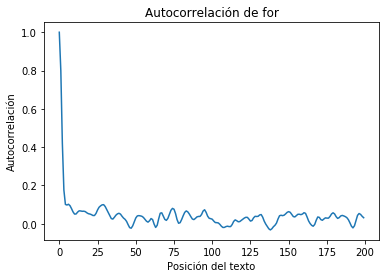

In [18]:
# Por cada una de las 3 palabras que se mencionan en el paper, 'plants', 'instinct' y 'for',
# graficamos sus apariciones y la autocorrelación
graficos(words,tokens)

### 3) Calcular la entropía de una selección de 100 palabras que abarquen el rango de frecuencia de aparición en el libro, es decir, elegir palabras que son muy frecuentes y otras de baja frecuencia

In [28]:
def calcular_particiones(apparitions,i,cota):
    return len(list(filter(lambda x: i*cota <= x < (i+1)*cota, apparitions)))

def H(apparitions, P, longitud_P, n):
    ocurrencias = [calcular_particiones(apparitions, i, longitud_P) for i in range(P)] 
    acum = 0
    for i in range(P):
        calculo = ocurrencias[i] / n
        if calculo != 0:
            acum += calculo * math.log2(calculo)
    
    return - acum

def entropy(word,tokens):
    apparitions = generate_apparitions_vector(word,tokens)

    N = text_size
    P = 64
    longitud_P = N // P
    
    n = len(apparitions)

    return n, H(apparitions, P, longitud_P, n)
    
def entropy_plot(palabras, tokens, title, log):
    a = [entropy(w, tokens) for w in palabras]
    plt.scatter([x[0] for x in a], [x[1] for x in a], s=3)
    if(log):
        plt.xscale("log", nonposx='clip')
    plt.xlabel('Cantidad de apariciones')
    plt.ylabel('Entropía [bits]')
    plt.title(title)
    plt.show()

In [20]:
# Por cada palabra, nos guardamos la cantidad de aparciones, para luego obtener las 100
# que representen el rango completo
app_dicc = {}
for w in set(tokens):
    app_dicc[w] = len(generate_apparitions_vector(w,tokens))
    
apariciones = sorted(app_dicc.items(), key=lambda x:x[1])

In [21]:
# Tomamos las 100 palabras de manera tal que representen el rango completo de fecuencias de palabras
# desde la de menor cantidad de aparicione, hasta la mayor, pasando por todos los valores intermedios
palabras = [apariciones[i][0] for i in np.arange(0, len(apariciones), len(apariciones)//100)]

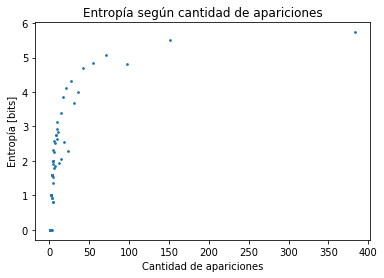

In [29]:
# graficamos la entropía de las 100 palabras que representan el rango
entropy_plot(palabras,tokens, 'Entropía según cantidad de apariciones', False)

### 4) Calcular la entropíade las palabras seleccionadas anteriormente, randomizando su posición en el texto. Compara los resultados con el punto anterior

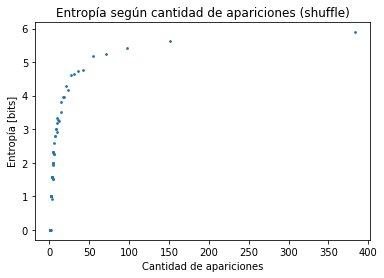

In [30]:
# Shuffleamos el texto y graficamos nuevamente la entropía para la cantidad de apariciones
# de palabras que cubran el rango
random_tokens = list(tokens)
random.shuffle(random_tokens)
random.shuffle(random_tokens)
random.shuffle(random_tokens)
random.shuffle(random_tokens)
random.shuffle(random_tokens)

entropy_plot(palabras,random_tokens, 'Entropía según cantidad de apariciones (shuffle)', False)

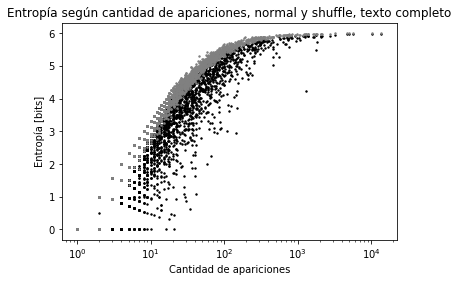

In [31]:
# Graficamos también, siguiendo el paper, la entropía de todas las palabras, 
# tanto para el texto normal, como shuffleado.

palabras_full = [p[0] for p in apariciones]
a = [entropy(w, tokens) for w in palabras_full]
b = [entropy(w, random_tokens) for w in palabras_full]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter([x[0] for x in a], [x[1] for x in a], s=2, color='black')
ax.scatter([x[0] for x in b], [x[1] for x in b], s=2, color='grey')
ax.set_xscale("log", nonposx='clip')
plt.xlabel('Cantidad de apariciones')
plt.ylabel('Entropía [bits]')
plt.title('Entropía según cantidad de apariciones, normal y shuffle, texto completo')
plt.show()

## Word embeddings, distancia semantica y WordNet

### 1) Utilizando el test WordSim353, comparar el rendimiento de LSA y Word2Vec 

##### WORDSIM 353

In [282]:
wordsim_words_file = 'data/wordsim353/wordsim353_annotator1.txt'
ignored_lines = 10
upper = lambda x: x.upper()
df_classifications = pd.read_table(filepath_or_buffer=wordsim_words_file, delim_whitespace=True, skiprows=ignored_lines, header=0, names=['word1', 'word2', 'wordsim353'], usecols=[1,2,3], converters={1: upper, 2: upper})

In [283]:
# Clasificaciones de wordsim
# Imprimimos los primeros 20 a modo de ejemplo
df_classifications[:20]

,word1,word2,wordsim353
0,LOVE,SEX,6.77
1,TIGER,CAT,7.35
2,TIGER,TIGER,10.00
3,BOOK,PAPER,7.46
4,COMPUTER,KEYBOARD,7.62
5,COMPUTER,INTERNET,7.58
6,PLANE,CAR,5.77
7,TRAIN,CAR,6.31
8,TELEPHONE,COMMUNICATION,7.50
9,TELEVISION,RADIO,6.77


##### WORD2VEC

In [284]:
# Creamos el modelo de word2Vec entrenandolo con el corpus de ap.
modelWord2Vec = models.Word2Vec(docs_words.values(), size=100, window=5, min_count=5, workers=4)

In [285]:
def word2vecSimilarity(word1, word2):
    try:
        return modelWord2Vec.similarity(word1, word2)
    except:
        return -1.0

##### LSA

In [286]:
# Creamos el modelo de LSA entrenandolo también con ap.
dictionary = corpora.Dictionary(docs_words.values())
corpus = [dictionary.doc2bow(text) for text in docs_words.values()]
lsiModel = models.LsiModel(corpus, id2word=dictionary, num_topics=4)

In [287]:
def lsaSimilarity(word1, word2):
    vec1 = dictionary.doc2bow([word1])
    vec2 = dictionary.doc2bow([word2])
    if len(vec1) > 0 and len(vec2) > 0:
        return 1 - sp.spatial.distance.cosine(np.array(lsiModel[vec1])[:,1], np.array(lsiModel[vec2])[:,1])
    else:
        return -1.0

#### COMPARACIONES

In [288]:
# Clasificamos con word2vec y LSA
df_classifications['word2vec'] = df_classifications.apply(func=lambda x: word2vecSimilarity(x[0], x[1]), axis=1)
df_classifications['lsa'] = df_classifications.apply(func=lambda x: lsaSimilarity(x[0], x[1]), axis=1)

# Imprimimos los primeros 20 a modo de ejemplo
df_classifications[:20]

,word1,word2,wordsim353,word2vec,lsa
0,LOVE,SEX,6.77,0.912593,0.872907
1,TIGER,CAT,7.35,0.968877,0.983643
2,TIGER,TIGER,10.00,1.000000,1.000000
3,BOOK,PAPER,7.46,0.939409,-0.134362
4,COMPUTER,KEYBOARD,7.62,-1.000000,-0.617238
5,COMPUTER,INTERNET,7.58,-1.000000,0.898419
6,PLANE,CAR,5.77,0.778773,0.789470
7,TRAIN,CAR,6.31,0.876012,0.733177
8,TELEPHONE,COMMUNICATION,7.50,0.844704,0.695716
9,TELEVISION,RADIO,6.77,0.912923,-0.075549


In [289]:
# Normalizamos los valores
min_max_scaler = sk.preprocessing.MinMaxScaler()
df_classifications[['wordsim353']] = min_max_scaler.fit_transform(df_classifications['wordsim353'].values.reshape(-1,1))
df_classifications[['word2vec']] = min_max_scaler.fit_transform(df_classifications['word2vec'].values.reshape(-1,1))
df_classifications[['lsa']] = min_max_scaler.fit_transform(df_classifications['lsa'].values.reshape(-1,1))

# Imprimimos los primeros 20 como ejemplo
df_classifications[:20]

,word1,word2,wordsim353,word2vec,lsa
0,LOVE,SEX,0.669396,0.956297,0.936453
1,TIGER,CAT,0.728762,0.984439,0.991822
2,TIGER,TIGER,1.000000,1.000000,1.000000
3,BOOK,PAPER,0.740020,0.969705,0.432819
4,COMPUTER,KEYBOARD,0.756397,0.000000,0.191381
5,COMPUTER,INTERNET,0.752303,0.000000,0.949209
6,PLANE,CAR,0.567042,0.889387,0.894735
7,TRAIN,CAR,0.622313,0.938006,0.866589
8,TELEPHONE,COMMUNICATION,0.744115,0.922352,0.847858
9,TELEVISION,RADIO,0.669396,0.956461,0.462226


In [290]:
# Comparamos las clasificaciones calculando la distancia euclideana de word2vec y LSA a wordsim353 
dist_word2vec = sp.spatial.distance.euclidean(df_classifications[['wordsim353']], df_classifications[['word2vec']])
dist_lsa = sp.spatial.distance.euclidean(df_classifications[['wordsim353']], df_classifications[['lsa']])

print("Distancia entre wordsim353 y word2vec: ", dist_word2vec)
print("Distancia entre wordsim353 y LSA: ", dist_lsa)

Distancia entre wordsim353 y word2vec:  8.880662336450156
Distancia entre wordsim353 y LSA:  6.710796363268974


### 2) Compara los distintos word embeddings con las medidas definidos en WordNet

In [291]:
def wordnet_similarity(word1, word2, function):
    synsets_word1 = wordnet.synsets(word1)
    synsets_word2 = wordnet.synsets(word2)
    if len(synsets_word1) > 0 and len(synsets_word2) > 0:
        try:
            similarity = function(synsets_word1[0], synsets_word2[0])
            return similarity if similarity else -1.0
        except:
            return -1.0
    else:
        return -1.0

In [292]:
def wordnet_path_similarity(word1, word2):
    return wordnet_similarity(word1, word2, wordnet.path_similarity)

In [293]:
def wordnet_wup_similarity(word1, word2):
    return wordnet_similarity(word1, word2, wordnet.wup_similarity)

In [294]:
def wordnet_lch_similarity(word1, word2):
    return wordnet_similarity(word1, word2, wordnet.lch_similarity)

In [295]:
def compare_embeddings(measure_name, measure_similarity_func):
    df_classifications[measure_name] = df_classifications.apply(func=lambda x: measure_similarity_func(x[0], x[1]), axis=1).fillna(-1.0)
    df_classifications[measure_name] = min_max_scaler.fit_transform(df_classifications[measure_name].values.reshape(-1,1))

    # Comparamos las clasificaciones calculando la distancia euclideana a word2vec y a LSA 
    dist_word2vec = sp.spatial.distance.euclidean(df_classifications[[measure_name]], df_classifications[['word2vec']])
    dist_lsa = sp.spatial.distance.euclidean(df_classifications[[measure_name]], df_classifications[['lsa']])

    print('Distancia entre word2vec y', measure_name,': ', dist_word2vec)
    print('Distancia entre lsa y', measure_name,': ', dist_lsa)


##### PATH SIMILARITY

In [296]:
compare_embeddings('wordnet_path', wordnet_path_similarity)

Distancia entre word2vec y wordnet_path :  7.817155236866945
Distancia entre lsa y wordnet_path :  5.71218223275545


##### WUP SIMILARITY

In [297]:
compare_embeddings('wordnet_wup', wordnet_wup_similarity)

Distancia entre word2vec y wordnet_wup :  7.829472553951136
Distancia entre lsa y wordnet_wup :  5.958327200076863


##### LCH SIMILARITY

In [298]:
compare_embeddings('wordnet_lch', wordnet_lch_similarity)

Distancia entre word2vec y wordnet_lch :  8.31976078993788
Distancia entre lsa y wordnet_lch :  6.4264450761778225


In [299]:
# Finalmente, las clasificaciones quedan del siguiente modo (Imprimimos 20 a modo de ejemplo)
df_classifications[:20]

,word1,word2,wordsim353,word2vec,lsa,wordnet_path,wordnet_wup,wordnet_lch
0,LOVE,SEX,0.669396,0.956297,0.936453,0.541667,0.576923,0.464181
1,TIGER,CAT,0.728762,0.984439,0.991822,0.545455,0.772727,0.482943
2,TIGER,TIGER,1.000000,1.000000,1.000000,1.000000,0.875000,1.000000
3,BOOK,PAPER,0.740020,0.969705,0.432819,0.538462,0.625000,0.446921
4,COMPUTER,KEYBOARD,0.756397,0.000000,0.191381,0.625000,0.911765,0.701074
5,COMPUTER,INTERNET,0.752303,0.000000,0.949209,0.562500,0.815789,0.551611
6,PLANE,CAR,0.567042,0.889387,0.894735,0.555556,0.833333,0.526214
7,TRAIN,CAR,0.622313,0.938006,0.866589,0.562500,0.833333,0.551611
8,TELEPHONE,COMMUNICATION,0.744115,0.922352,0.847858,0.535714,0.566667,0.430942
9,TELEVISION,RADIO,0.669396,0.956461,0.462226,0.666667,0.950000,0.763107
